In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import importlib
importlib.import_module("utils")
from utils.prepare_dataset import prepare_dataset_mnist

/home/dingkang/envs/nlp_a4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_GPU = True if torch.cuda.is_available() else "cpu"

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

batch_size = 64
loaded = np.load("dataset/raterized_building_shapes.npz")

split_ratio = 0.2
train_tokens, val_tokens, train_labels, val_labels = train_test_split(loaded["train_tokens"], loaded["train_labels"], test_size=split_ratio, random_state=42)

train_tokens = torch.tensor(train_tokens, dtype=torch.float32)
val_tokens = torch.tensor(val_tokens, dtype=torch.float32)
train_labels= torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)

train_tokens, val_tokens = train_tokens.unsqueeze(-1).permute(0, 3, 1, 2), val_tokens.unsqueeze(-1).permute(0, 3, 1, 2)

train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tokens, val_labels), batch_size=32)

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(train_tokens[267], cmap='gray')

In [5]:
train_tokens.shape

torch.Size([4000, 1, 28, 28])

In [17]:
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()
        act_fn = nn.ReLU
        self.net1 = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1),
            act_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True))
        
        self.net2 = nn.Sequential(nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1),
            act_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True))

        self.net3 = nn.Sequential(
            nn.Conv2d(18, 8, kernel_size=3, stride=1, padding=1),
            act_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1, return_indices=True),
        )

        self.flatten = nn.Flatten()


    def forward(self, x):
        x, indices1 = self.net1(x)
        x, indices2 = self.net2(x)
        x, indices3 = self.net3(x)
        x = self.flatten(x)
        return x, [indices1, indices2, indices3]
    

class Decoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.act_fn = nn.GELU()
        self.mup1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv1 = nn.ConvTranspose2d(8, 18, kernel_size=3, stride=1, padding=1)
        self.mup2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv2 = nn.ConvTranspose2d(18, 3, kernel_size=3, stride=1, padding=1)
        self.mup3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv3 = nn.ConvTranspose2d(3, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x, indices_list):
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.mup1(x, indices_list[2], output_size=(x.shape[0], x.shape[0], 7, 7))
        x = self.act_fn(self.conv1(x))
        x = self.mup2(x, indices_list[1])
        x = self.act_fn(self.conv2(x))
        x = self.mup3(x, indices_list[0])
        x = self.act_fn(self.conv3(x))
        return x
    
class PixelNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.loss_func = nn.MSELoss()

    def forward(self, x):
        hidden, indices_list = self.encoder(x)
        output = self.decoder(hidden, indices_list)
        # loss = F.mse_loss(x, output, reduction="none")
        # loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        # loss = F.mse_loss(x, output)
        return hidden, output

In [22]:
pixelnet = PixelNet()
loss_func = nn.MSELoss()
optimizer = optim.Adam(pixelnet.parameters(), lr=0.004)

num_epoch = 50

for epoch in range(num_epoch):
    pixelnet.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        hidden, outputs = pixelnet(inputs)
        loss = F.mse_loss(inputs, outputs, reduction="none")
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    train_loss = total_loss/len(train_loader)

    pixelnet.eval()
    with torch.no_grad():
        val_hidden, val_outputs= pixelnet(train_tokens)
        val_loss = loss.item()
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

Epoch 1, Train Loss: 194.88424728393554, Val Loss: 63.36893844604492
Epoch 2, Train Loss: 45.34674331665039, Val Loss: 34.681190490722656
Epoch 3, Train Loss: 28.895610610961914, Val Loss: 25.618362426757812
Epoch 4, Train Loss: 24.411843688964844, Val Loss: 23.344135284423828
Epoch 5, Train Loss: 22.332541625976564, Val Loss: 20.873029708862305
Epoch 6, Train Loss: 20.728854232788088, Val Loss: 18.627845764160156
Epoch 7, Train Loss: 19.26760185241699, Val Loss: 18.48287582397461
Epoch 8, Train Loss: 18.189140670776368, Val Loss: 18.13300323486328
Epoch 9, Train Loss: 17.266289192199707, Val Loss: 18.55262565612793
Epoch 10, Train Loss: 16.752227882385252, Val Loss: 17.03911590576172
Epoch 11, Train Loss: 16.184907218933105, Val Loss: 15.193075180053711
Epoch 12, Train Loss: 15.609210357666015, Val Loss: 15.018388748168945
Epoch 13, Train Loss: 14.989062278747559, Val Loss: 15.0859375
Epoch 14, Train Loss: 13.390974891662598, Val Loss: 12.058895111083984
Epoch 15, Train Loss: 12.57587

In [20]:
from utils.embeding_evaluate import compute_NN, compute_FT, compute_ST

show_hidden = val_hidden.reshape(val_hidden.size(0), -1)
show_labels = train_labels

"Embedding", compute_NN(show_hidden, show_labels), compute_FT(show_hidden, show_labels), compute_ST(show_hidden, show_labels)

('Embedding', 0.8845, 0.2504146161207154, 0.35996596282719723)

In [21]:
from utils.embeding_evaluate import compute_NN, compute_FT, compute_ST

show_hidden = train_tokens.reshape(train_tokens.size(0), -1)
show_labels = train_labels

"Original", compute_NN(show_hidden, show_labels), compute_FT(show_hidden, show_labels), compute_ST(show_hidden, show_labels)

('Original', 0.89025, 0.26796002352881204, 0.37918239282653887)

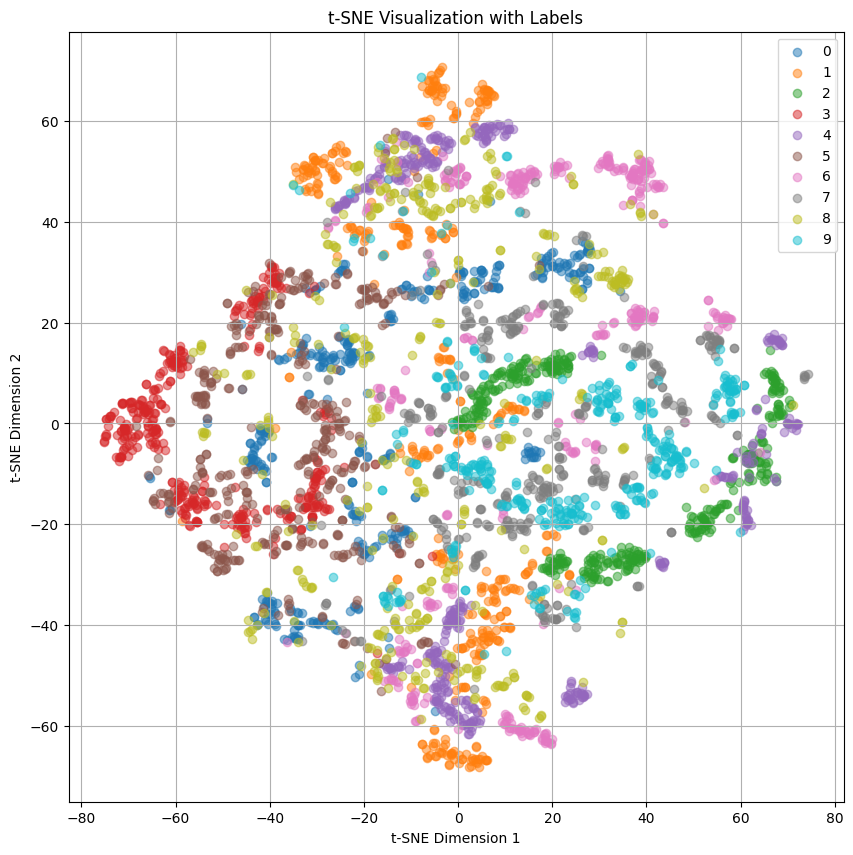

In [35]:
show_hidden = val_hidden.reshape(val_hidden.size(0), -1)
show_labels = train_labels

# show_hidden = train_tokens.reshape(train_tokens.size(0), -1)
# show_labels = train_labels

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np


tsne = TSNE(n_components=2, init='pca', random_state=0)
projections = tsne.fit_transform(show_hidden)

plt.figure(figsize=(10, 10))

# Plot each class separately
for label in np.unique(show_labels):
    indices = show_labels == label
    plt.scatter(projections[indices, 0], projections[indices, 1], label=label, alpha=0.5)

plt.title('t-SNE Visualization with Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
pixelnet.eval()
with torch.no_grad():
    cls_train_hidden = pixelnet(train_tokens)[0].view(train_tokens.size(0), -1)
    cls_val_hidden = pixelnet(val_tokens)[0].view(val_tokens.size(0), -1)

    # tsne = PCA(n_components=64, random_state=0)
    # train_hidden = torch.tensor(tsne.fit_transform(train_hidden), dtype=torch.float32)
    # val_hidden = torch.tensor(tsne.transform(val_hidden), dtype=torch.float32)

# # Without encoding
# cls_train_hidden = train_tokens.reshape(train_tokens.size(0), -1)
# cls_val_hidden = val_tokens.reshape(val_tokens.size(0), -1)

cls_train_loader = DataLoader(TensorDataset(cls_train_hidden, train_labels), batch_size=batch_size, shuffle=True)

In [37]:
# Define the classifier
class Classifier(nn.Module):
    def __init__(self, input_size, dense_size, num_classes, dropout):
        super().__init__()
        self.dense1 = nn.Linear(input_size, dense_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_size, num_classes)

    def forward(self, x):
        x = self.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        # # Linear probing
        # x = self.dense1(x)

        return x
    
classifier = Classifier(cls_train_hidden.size(1), 128, 10, 0.0)

if USE_GPU:
    classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.004)
# optimizer = optim.Adam(classifier.parameters(), lr=0.004, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)

num_epochs = 100

def train(model, loader):
    model.eval()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_x, batch_y in loader:
        if USE_GPU:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, dim=-1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    train_loss /= len(loader)
    train_acc = correct / total
    return train_loss, train_acc

def evaluate(model, tokens, labels):
    model.eval()
    with torch.no_grad():
        if USE_GPU:
            tokens, labels = tokens.to(device), labels.to(device)
        outputs = model(tokens)
        eval_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, dim=-1)
        eval_acc = (predicted == labels).sum().item() / labels.size(0)
    return eval_loss, eval_acc

for epoch in range(num_epochs):
    train_loss, train_acc = train(classifier, cls_train_loader)
    val_loss, val_acc = evaluate(classifier, cls_val_hidden, val_labels)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Train Acc {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}")


# # Test
# test_loss, test_acc = evaluate(classifier, test_loader)
# print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

Epoch: 1, Train Loss: 1.424563085275983, Train Acc 0.51225, Val Loss: 0.9653065800666809, Val Acc: 0.664
Epoch: 2, Train Loss: 0.7085119646693033, Train Acc 0.75225, Val Loss: 0.5524961948394775, Val Acc: 0.81
Epoch: 3, Train Loss: 0.5021760941497864, Train Acc 0.824, Val Loss: 0.4674718379974365, Val Acc: 0.836
Epoch: 4, Train Loss: 0.3938976183297142, Train Acc 0.86975, Val Loss: 0.38440850377082825, Val Acc: 0.862
Epoch: 5, Train Loss: 0.3349477192239156, Train Acc 0.88375, Val Loss: 0.35844913125038147, Val Acc: 0.88
Epoch: 6, Train Loss: 0.2997660544656572, Train Acc 0.89875, Val Loss: 0.33468538522720337, Val Acc: 0.885
Epoch: 7, Train Loss: 0.2496084263400426, Train Acc 0.918, Val Loss: 0.2847004234790802, Val Acc: 0.904
Epoch: 8, Train Loss: 0.2153578865386191, Train Acc 0.936, Val Loss: 0.2663603127002716, Val Acc: 0.906
Epoch: 9, Train Loss: 0.19026544832047962, Train Acc 0.94275, Val Loss: 0.25562742352485657, Val Acc: 0.912
Epoch: 10, Train Loss: 0.1661625456005808, Train A